<a href="https://colab.research.google.com/github/yf257/tensorflow-deep-learning/blob/main/Food101_efficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project1: Food Vision Big

## Check GPU

* not all GPU compatible with mixed precision training

google colob offer
* K80(not compatible)
* P100(not compatible)
* Tesla T4 (compatible)

Knowing this, need to make sure score of 7.0+ to achieve boosted performance with mixed precision training

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-db95d598-ff0e-309d-dddb-63bc02310778)


## Get helper functions



In [2]:
# download helper function script
!wget https://github.com/yf257/tensorflow-deep-learning/raw/main/helper_functions.py

--2022-01-30 20:25:13--  https://github.com/yf257/tensorflow-deep-learning/raw/main/helper_functions.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yf257/tensorflow-deep-learning/main/helper_functions.py [following]
--2022-01-30 20:25:13--  https://raw.githubusercontent.com/yf257/tensorflow-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-30 20:25:13 (83.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]

In [3]:
# Import helper function

from helper_functions import create_tensorboard_callback, plot_loss_curves,compare_historys

## Use TensorFlow Dataset to download data

In [4]:
# Get tensorflow datasets
import tensorflow_datasets as tfds



In [5]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [6]:
#Load in the data (take 5-6 minutes in Google Colab)
(train_data,test_data),ds_info = tfds.load("food101",
                                           split = ["train","validation"],
                                           shuffle_files = True,
                                           as_supervised = True,
                                           with_info = True
                                           
                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQDKTF9/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQDKTF9/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Features of Food 101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names 

class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

* Class names
* shape of input data(image)
* The datatype of input data
* what the labels look like

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [10]:
# output info about our training sample
for image,label in train_one_sample:
  print(f"""
  Image shape:{image.shape},
  Image datatype:{image.dtype},
  Target class from Food101(tensorform):{label},
  Class name (str form): {class_names[label.numpy()]}""")


  Image shape:(512, 512, 3),
  Image datatype:<dtype: 'uint8'>,
  Target class from Food101(tensorform):8,
  Class name (str form): bread_pudding


In [11]:
# What does the image tensor from TFDS's Food101 looks like
label


<tf.Tensor: shape=(), dtype=int64, numpy=8>

In [12]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow dataset

(-0.5, 511.5, 511.5, -0.5)

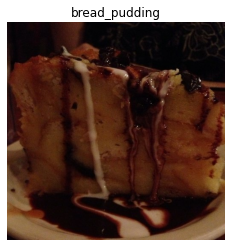

In [13]:
#Plot an image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions for our data
Neural networks perform best when data is in certain way(batched, normalized)
so in order to get it ready , need to write preprocessing functions and map it to data

What we know about our data:
* in 'uint8'
* comprised of all different size tensors (different sized images)
* Not scaled(the pixel values are between 0 and 255)

what our model like:
* data in 'float32' dtype(or for mixed precision 'float16' and 'float32')
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled( values between 0 and 1) also called normalized tensors generally perform better


This mean our function needs to 

1. Reshape our images to all same size
2. Convert the dtype from unit8 to float32


In [14]:
# Make a function for preprocessing images
def preprocess_img(image,label,img_shape = 224):
  """
  Converts image datatype from 'uint8'-> 'float32' and reshapes
  image to [img_shape,img_shape,color_channel]
  """
  image = tf.image.resize(image,[img_shape,img_shape])
  #image = image/255.  ## if not using efficientnet, need to rescale
  return tf.cast(image,tf.float32),label


In [15]:
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n{image[:2]}...,\nShape:{image.shape},\nDatatype:{image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape},\nDatatype:{preprocessed_img.dtype}\n")

Image before preprocessing:
[[[18  6  8]
  [18  6  8]
  [18  6  8]
  ...
  [30 15 22]
  [29 14 21]
  [26 11 18]]

 [[22 10 12]
  [21  9 11]
  [20  8 10]
  ...
  [35 20 27]
  [31 16 23]
  [26 11 18]]]...,
Shape:(512, 512, 3),
Datatype:<dtype: 'uint8'>

Image after preprocessing:
[[[20.158163   8.158163  10.158163 ]
  [18.42347    7.6173472  9.020408 ]
  [15.010203   6.423469   9.285714 ]
  ...
  [26.285824  15.714351  23.07156  ]
  [31.091867  17.285728  24.285728 ]
  [28.754953  13.754952  20.754953 ]]

 [[18.92857    8.928571   9.928571 ]
  [16.214285   7.0765305  8.07653  ]
  [14.739796   8.571429  10.627551 ]
  ...
  [26.444029  15.872557  21.658293 ]
  [39.86226   26.862259  33.86226  ]
  [39.49479   24.494787  31.494787 ]]]...,
Shape:(224, 224, 3),
Datatype:<dtype: 'float32'>



## Batch and prepare datasets

We're now going to make the data input pipeline

reference:
https://www.tensorflow.org/guide/data

In [16]:
# Map preprocessing function to training (prallelize)
train_data = train_data.map(map_func = preprocess_img,num_parallel_calls = tf.data.AUTOTUNE)
# shuffle train_data and turn it into batches and prefetch it 
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test dat

test_data = test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data,test_data


(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks

* Tensorboard callback
* ModelCheckpoint callback 

In [18]:
# Create tensorboard calback(import from helper function )
from helper_functions import create_tensorboard_callback

# create model checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monotor = "val_acc",save_best_only="True",save_weights_only=True,verbose = 0)

In [19]:
tf.__version__

'2.7.0'

## Setup mixed precision training

mixed precision utilizeds a combination of float32 and float16

https://www.tensorflow.org/guide/mixed_precision

In [20]:
# Turn on mixed precision trianing

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Build feature extraction model



In [21]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape,name = "input_layer")
# x  = preprocessing.Rescaling(1./255) #if not using efficientnet
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype = tf.float32,name = "softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [23]:
# compile
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [25]:
# check the dtype of each layers
for layer in model.layers:
  print(model.name,layer.trainable,layer.dtype,layer.dtype_policy)

model True float32 <Policy "float32">
model False float32 <Policy "mixed_float16">
model True float32 <Policy "mixed_float16">
model True float32 <Policy "mixed_float16">
model True float32 <Policy "float32">


In [26]:
# check the dtype of base model layers
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

### fit the feature extraction model
goal: fine-tune a pretrained model, general order is 
1. Build a feature extraction model
2. Fine-tune some of the frozen layers

In [27]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,epochs=3,steps_per_epoch = len(train_data),validation_data=test_data,validation_steps=int(0.15*len(test_data)),callbacks = [create_tensorboard_callback(dir_name="training_logs",experiment_name="efficientnet0_101"),model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet0_101/20220130-203532
Epoch 1/3

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



2368/2368 [==============================] - 187s 71ms/step - loss: 1.8191 - accuracy: 0.5573 - val_loss: 1.2286 - val_accuracy: 0.6758
Epoch 2/3
2368/2368 [==============================] - 168s 70ms/step - loss: 1.2927 - accuracy: 0.6671 - val_loss: 1.1309 - val_accuracy: 0.7013
Epoch 3/3
2368/2368 [==============================] - 166s 69ms/step - loss: 1.1425 - accuracy: 0.7021 - val_loss: 1.0911 - val_accuracy: 0.7031


In [28]:
result_feature_extract_model =model.evaluate(test_data)
result_feature_extract_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0917 - accuracy: 0.7067


[1.0916709899902344, 0.7066930532455444]

## Save the trained model

In [29]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [30]:
# Load the saved model for fine tuning
saved_model = tf.keras.models.load_model("saved_model/my_model")

In [31]:
# check saved model performance

result_feature_extract_loaded = saved_model.evaluate(test_data)

790/790 [==============================] - 71s 87ms/step - loss: 1.0917 - accuracy: 0.7067


In [32]:
saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Prepare model for fine-tuning


In [33]:
saved_model.layers[1].trainable=True


In [34]:
## Set up call backs to stop training if model's val_loss is not improving for 3 epochs

EarlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=0,
                                                      patience=3,
                                                      verbose = 0,
                                                      mode='auto',
                                                      baseline = None,
                                                      restore_best_weights = False
                                                      )

In [35]:
## Create ModelCheckpoint callback to save the best performing model during training

checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights require ".ckpt" extension
Checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True)

In [36]:
#Compile the model

saved_model.compile(loss = "sparse_categorical_crossentropy",
                      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      metrics = ["accuracy"]
                )

In [37]:
# Train the model for fine-tuning
result_feature_extract_fine_tune = saved_model.fit(train_data,epochs= 100,steps_per_epoch=len(train_data),validation_data=test_data,
                                                     validation_steps = int(0.15*len(test_data)),callbacks = [create_tensorboard_callback(dir_name="Fine_tune",experiment_name="trial1"),
                                                                               EarlyStop_callback,  Checkpoint_callback                             ])

Saving TensorBoard log files to: Fine_tune/trial1/20220130-213847


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - 349s 141ms/step - loss: 0.9231 - accuracy: 0.7533 - val_loss: 0.7889 - val_accuracy: 0.7802
Epoch 2/100
2368/2368 [==============================] - 335s 141ms/step - loss: 0.5803 - accuracy: 0.8402 - val_loss: 0.7845 - val_accuracy: 0.7881
Epoch 3/100
2368/2368 [==============================] - 336s 141ms/step - loss: 0.3290 - accuracy: 0.9063 - val_loss: 0.8791 - val_accuracy: 0.7818
Epoch 4/100
2368/2368 [==============================] - 331s 139ms/step - loss: 0.1761 - accuracy: 0.9482 - val_loss: 0.9950 - val_accuracy: 0.7765
Epoch 5/100
2368/2368 [==============================] - 331s 139ms/step - loss: 0.1091 - accuracy: 0.9666 - val_loss: 1.0764 - val_accuracy: 0.7807


In [38]:
# Save the model 

saved_model.save('fine_tuned_model/saved_model')

INFO:tensorflow:Assets written to: fine_tuned_model/saved_model/assets


INFO:tensorflow:Assets written to: fine_tuned_model/saved_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [39]:
saved_model.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 1.0596 - accuracy: 0.7781


[1.0595662593841553, 0.7780594229698181]

## View the training results on TensorBoard

In [40]:
!tensorboard dev upload --logdir ./Fine_tune \
--name "Transfer Learning Eperiments with 10 Food101 Classes" \
--description "A series of different transfer learning experiments with verying amount of data" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./Fine_tune

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) No


## Evaluate the trained model

In [42]:
preds_probs = saved_model.predict(test_data,verbose = 1)
preds_probs[:4]

790/790 [==============================] - 53s 63ms/step


array([[1.12988570e-10, 8.09192380e-10, 5.68142200e-11, 9.98610258e-01,
        3.26451499e-07, 2.01120955e-07, 1.43046097e-13, 7.26448036e-13,
        1.59339431e-10, 1.35514222e-09, 1.45472386e-05, 1.76478011e-06,
        2.95192303e-14, 1.27840252e-07, 1.03466385e-11, 2.00818424e-04,
        3.72596780e-11, 7.83116491e-07, 6.56683063e-09, 6.81815345e-06,
        9.60939661e-10, 3.08893605e-11, 1.77755990e-10, 2.22822842e-14,
        6.13384188e-08, 2.35488407e-10, 7.72136743e-10, 3.15554635e-12,
        3.66820185e-11, 9.71976753e-12, 6.64225480e-11, 1.90303797e-11,
        4.42469603e-11, 5.77089140e-11, 2.94304954e-08, 8.97579433e-09,
        6.52944081e-08, 2.08693471e-08, 2.22487688e-11, 2.19630442e-06,
        1.04497341e-10, 1.63707589e-12, 1.37855612e-12, 2.04595868e-10,
        3.00651437e-09, 3.86625627e-12, 1.52683395e-08, 5.49834027e-08,
        3.09728557e-06, 5.33720221e-11, 3.07134790e-10, 7.83116491e-07,
        1.34945596e-11, 7.44119477e-09, 1.35718368e-12, 2.653239

In [44]:
pred_classes= preds_probs.argmax(axis = 1)
pred_classes[:20]

array([ 3, 73, 81, 60, 29, 80, 32, 78, 17,  1, 40, 40, 99, 77, 71, 77, 85,
       44, 91, 76])

In [ ]:
# Get the test labels for comparison
y_labels = []
y_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
  #y_images.append(images)
y_labels[:20]